In [13]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Parts we added
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

## We created functions to get SIFT descriptors and calculate Dense SIFT

In [3]:
def create_dense_kp(img_shape, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size) 
                                          for x in range(0, img_shape[1], step_size)]

def get_descriptors(dense=True, feat_num=250, step_size=20, mode="train"):
    
    descriptors = []
    label_per_descriptor = []
    
    if mode == "train":        
        img_filenames = train_images_filenames
        lbl_filenames = train_labels
        
    else:
        img_filenames = test_images_filenames
        lbl_filenames = test_labels
        
    Detector = cv2.SIFT_create(feat_num)

    for filename,labels in zip(img_filenames, lbl_filenames):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        
        if not dense:
            kpt, des=Detector.detectAndCompute(gray,None)
            
        else:
            kpt = create_dense_kp(gray.shape, step_size=step_size)                              
            _, des = Detector.compute(gray, kpt)
            
        descriptors.append(des)
        label_per_descriptor.append(labels)
    
    return descriptors, label_per_descriptor

## This function is used to find visual words

In [4]:
def get_visual_words(descriptors, k=128):
    
    D = np.vstack(descriptors)
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k*20, compute_labels=False,
                               reassignment_ratio=10**-4, random_state=42)
    codebook.fit(D)
    
    visual_words=np.zeros((len(descriptors), k),dtype=np.float32)
    
    for i in range(len(descriptors)):
        words=codebook.predict(descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
        
    return codebook, visual_words

## We get the most common words for each class and plot them to see if there are any significant differences between them.

In [31]:
Train_descriptors, train_labels = get_descriptors(dense=False, feat_num=500)
codebook, visual_words = get_visual_words(Train_descriptors, 128)

class_dict = {}

for lbl, elem in zip(train_labels, visual_words):
    if lbl not in class_dict.keys():
        class_dict[lbl] = np.argsort(elem)[::-1][:10]
    else:
        class_dict[lbl] = np.concatenate((class_dict[lbl], np.argsort(elem)[::-1][:10]))

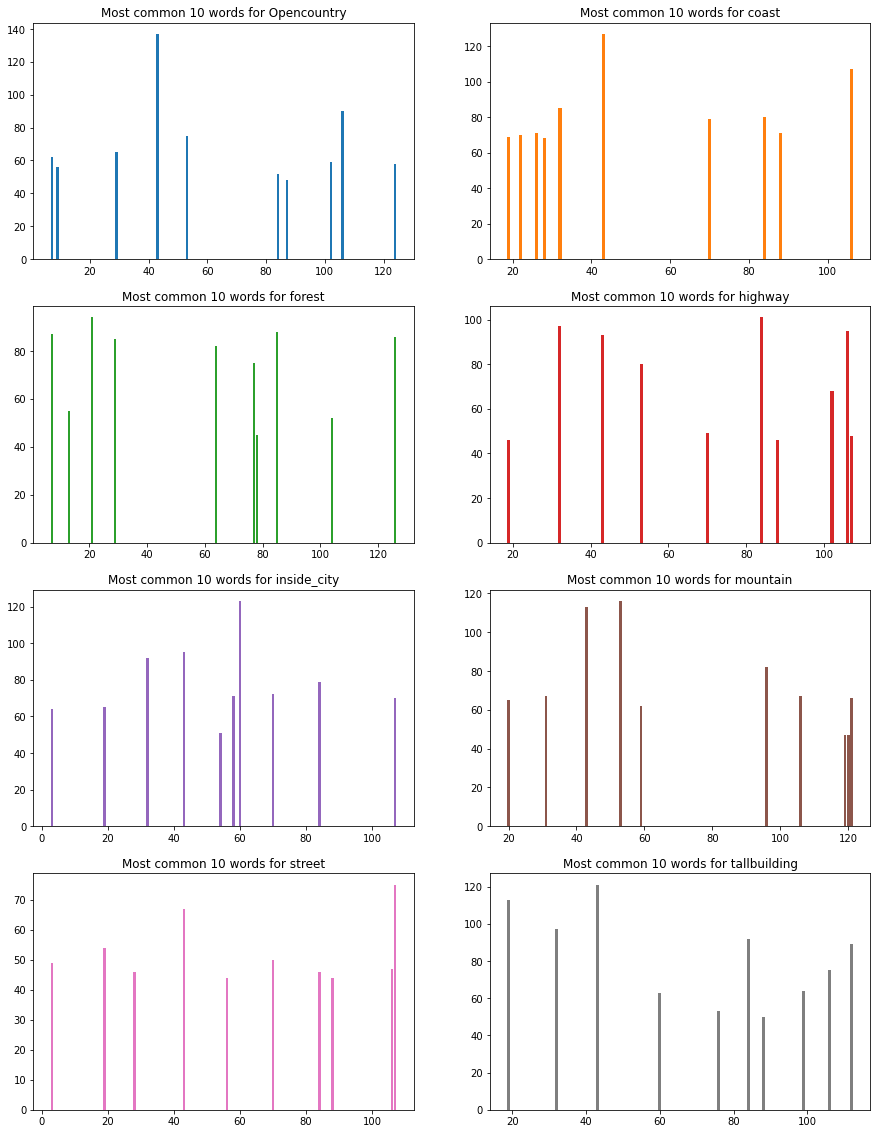

In [87]:
colors = plt.rcParams["axes.prop_cycle"]()

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

for num, key in enumerate(class_dict.keys()):
    c = next(colors)["color"]
    i = int(num/2)
    j = int(num%2)
    tmp_cls = pd.Series(class_dict[key]).value_counts()[:10]
    ax[i][j].bar(tmp_cls.index, tmp_cls.values, color=c)
    ax[i][j].title.set_text("Most common 10 words for " + key)

## Hyperparameter search for SIFT and KNN with cross validation

We tried different amount of local features, codebook sizes, distance metrics and n_neighbors.
Since this takes a lot of time we ran it once and put the results in a csv file. 
We did a grid search with splitting the data into 8 for cross validation.

You can get the results from the csv instead of running the cell below

In [7]:
knn_res_df = pd.read_csv("knn_hp_results.csv")

In [60]:
knn_res_df = pd.DataFrame(columns=["n_features", "codebook_size", "n_neighbors","dist_metric",
                                   "mean_train_acc", "mean_test_acc", "mean_train_f1", "mean_test_f1"])

params = {
    "n_features": np.arange(200, 800, 100),
    #"dense": [True, False],
    #"step_size": np.arange(10, 60, 10),
    "codebook_size": np.arange(32, 256, 32),
    "n_neighbors": np.arange(3, 9, 1),
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]
}

for n in params["n_features"]:
    Train_descriptors, train_labels = get_descriptors(dense=False, feat_num=n)
    for cs in params["codebook_size"]:
        codebook, visual_words = get_visual_words(Train_descriptors, cs)

        print(n, cs)

        knn = KNeighborsClassifier(n_jobs=-1)
        knn_grid = GridSearchCV(knn, {k:params[k] for k in ("n_neighbors", "metric") if k in params}, cv=8,
                                scoring=["accuracy", "f1_macro"], refit="accuracy", return_train_score=True)
        knn_grid.fit(visual_words, train_labels) 

        print("Finished this iteration!")
        best_acc = np.argmin(knn_grid.cv_results_["rank_test_accuracy"])
        knn_res_df = knn_res_df.append({
            "n_features": n,
            "codebook_size": cs,
            "n_neighbors": knn_grid.best_params_["n_neighbors"],
            "dist_metric": knn_grid.best_params_["metric"],
            "mean_train_acc": knn_grid.cv_results_["mean_train_accuracy"][best_acc], 
            "mean_test_acc": knn_grid.cv_results_["mean_test_accuracy"][best_acc], 
            "mean_train_f1": knn_grid.cv_results_["mean_train_f1_macro"][best_acc], 
            "mean_test_f1": knn_grid.cv_results_["mean_test_f1_macro"][best_acc]
        }, ignore_index=True)
        
knn_res_df.to_csv("knn_hp_results.csv", index=False)

200 32
Finished this iteration!
200 64
Finished this iteration!
200 96
Finished this iteration!
200 128
Finished this iteration!
200 160
Finished this iteration!
200 192
Finished this iteration!
200 224
Finished this iteration!
300 32
Finished this iteration!
300 64
Finished this iteration!
300 96
Finished this iteration!
300 128
Finished this iteration!
300 160
Finished this iteration!
300 192
Finished this iteration!
300 224
Finished this iteration!
400 32
Finished this iteration!
400 64
Finished this iteration!
400 96
Finished this iteration!
400 128
Finished this iteration!
400 160
Finished this iteration!
400 192
Finished this iteration!
400 224
Finished this iteration!
500 32
Finished this iteration!
500 64
Finished this iteration!
500 96
Finished this iteration!
500 128
Finished this iteration!
500 160
Finished this iteration!
500 192
Finished this iteration!
500 224
Finished this iteration!
600 32
Finished this iteration!
600 64
Finished this iteration!
600 96
Finished this ite

## Effect of N_features, Codebook size and N_neighbors

<AxesSubplot:xlabel='n_features'>

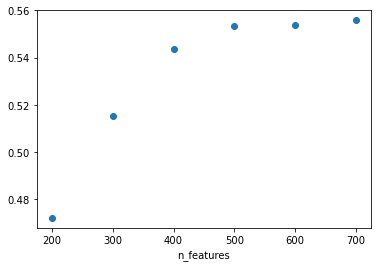

In [94]:
knn_res_df.groupby("n_features").mean()["mean_test_acc"].plot(marker='o', linestyle="None")

<AxesSubplot:xlabel='codebook_size'>

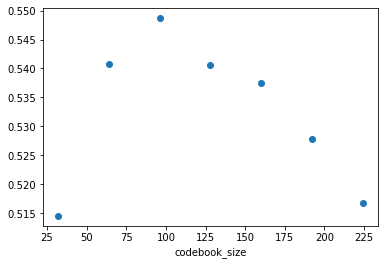

In [95]:
knn_res_df.groupby("codebook_size").mean()["mean_test_acc"].plot(marker='o', linestyle="None")

<AxesSubplot:xlabel='n_neighbors'>

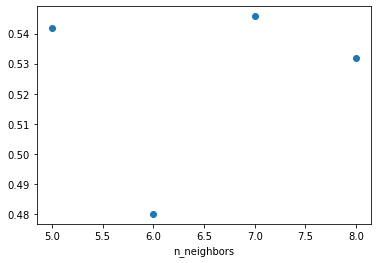

In [96]:
knn_res_df.groupby("n_neighbors").mean()["mean_test_acc"].plot(marker='o', linestyle="None")

## For SIFT, best combination is:

<b> N_features </b> = 500  <br>
<b> Codebook_size </b> = 96 <br>
<b> N_neighbors </b> = 8 <br>
<b> Distance_metric </b> = euclidean

<b> We can achieve a test accuracy of %58. </b>

In [7]:
knn_res_df.sort_values("mean_test_acc", ascending=False)

,n_features,codebook_size,n_neighbors,dist_metric,mean_train_acc,mean_test_acc,mean_train_f1,mean_test_f1
23,500,96,8,euclidean,0.684287,0.577385,0.682785,0.572716
29,600,64,7,euclidean,0.679654,0.571545,0.679639,0.566451
38,700,128,7,euclidean,0.681780,0.566221,0.681430,0.560637
16,400,96,8,euclidean,0.676920,0.566212,0.673437,0.557914
36,700,64,8,euclidean,0.679730,0.565157,0.680429,0.560943
24,500,128,8,euclidean,0.667729,0.561411,0.665346,0.552304
25,500,160,7,euclidean,0.668263,0.560916,0.668721,0.559370
37,700,96,8,euclidean,0.664692,0.559306,0.664418,0.555538
39,700,160,8,euclidean,0.667579,0.558774,0.665661,0.551355
31,600,128,8,euclidean,0.667199,0.558249,0.667474,0.554423


## Hyperparameter search for Dense-SIFT and KNN

We see that best n_feature size is 500 for SIFT, so we tried to tune the step size while keeping the n_features at 500.
We did a grid search with splitting the data into 8 for cross validation.

You can get the results from the csv instead of running the cell below.

In [8]:
knn_dSIFT_res_df = pd.read_csv("knn_dSIFT_res.csv")

In [88]:
knn_dSIFT_res_df = pd.DataFrame(columns=["step_size", "codebook_size", "n_neighbors","dist_metric",
                                   "mean_train_acc", "mean_test_acc", "mean_train_f1", "mean_test_f1"])

params = {
    #"dense": [True, False],
    "step_size": np.arange(10, 60, 10),
    "codebook_size": np.arange(64, 256, 32),
    "n_neighbors": np.arange(6, 9, 1),
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]
}

for ss in params["step_size"]:
    Train_descriptors, train_labels = get_descriptors(feat_num=500, step_size=int(ss))
    #Test_descriptors, test_labels = get_descriptors(False, n, ss, mode="test")

    for cs in params["codebook_size"]:
        codebook, visual_words = get_visual_words(Train_descriptors, cs)

        ##visual_words_test=np.zeros((len(test_labels),cs), dtype=np.float32)
        ##for i in range(len(Test_descriptors)):
        ##    words = codebook.predict(Test_descriptors[i])
        ##    visual_words_test[i,:] = np.bincount(words, minlength=cs)

        print(ss, cs)

        knn = KNeighborsClassifier(n_jobs=-1)
        knn_grid = GridSearchCV(knn, {k:params[k] for k in ("n_neighbors", "metric") if k in params}, cv=8,
                                scoring=["accuracy", "f1_macro"], refit="accuracy", return_train_score=True)
        knn_grid.fit(visual_words, train_labels) 

        #test_preds = knn_grid.predict(visual_words_test)
        #print(f1_score(test_labels, test_preds, average="micro"))
        print("Finished this iteration!")
        best_acc = np.argmin(knn_grid.cv_results_["rank_test_accuracy"])
        knn_dSIFT_res_df = knn_dSIFT_res_df.append({
            "step_size": ss,
            "codebook_size": cs,
            "n_neighbors": knn_grid.best_params_["n_neighbors"],
            "dist_metric": knn_grid.best_params_["metric"],
            "mean_train_acc": knn_grid.cv_results_["mean_train_accuracy"][best_acc], 
            "mean_test_acc": knn_grid.cv_results_["mean_test_accuracy"][best_acc], 
            "mean_train_f1": knn_grid.cv_results_["mean_train_f1_macro"][best_acc], 
            "mean_test_f1": knn_grid.cv_results_["mean_test_f1_macro"][best_acc]
        }, ignore_index=True)
        
knn_dSIFT_res_df.to_csv("knn_dSIFT_res.csv", index=False)

10 64
Finished this iteration!
10 96
Finished this iteration!
10 128
Finished this iteration!
10 160
Finished this iteration!
10 192
Finished this iteration!
10 224
Finished this iteration!
20 64
Finished this iteration!
20 96
Finished this iteration!
20 128
Finished this iteration!
20 160
Finished this iteration!
20 192
Finished this iteration!
20 224
Finished this iteration!
30 64
Finished this iteration!
30 96
Finished this iteration!
30 128
Finished this iteration!
30 160
Finished this iteration!
30 192
Finished this iteration!
30 224
Finished this iteration!
40 64
Finished this iteration!
40 96
Finished this iteration!
40 128
Finished this iteration!
40 160
Finished this iteration!
40 192
Finished this iteration!
40 224
Finished this iteration!
50 64
Finished this iteration!
50 96
Finished this iteration!
50 128
Finished this iteration!
50 160
Finished this iteration!
50 192
Finished this iteration!
50 224
Finished this iteration!


## Effect of step size. We can see that a smaller step size is better.

<AxesSubplot:xlabel='step_size'>

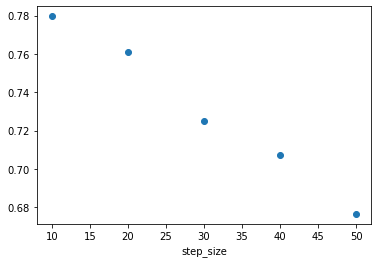

In [97]:
knn_dSIFT_res_df.groupby("step_size").mean()["mean_test_acc"].plot(marker='o', linestyle="None")

## For Dense-SIFT, best combination is:

<b> Step_size </b> = 10  <br>
<b> Codebook_size </b> = 224 <br>
<b> N_neighbors </b> = 8 <br>
<b> Distance_metric </b> = manhattan

 We can achieve a test accuracy of <b> %79.</b>

## Dense-SIFT clearly outperforms vanilla SIFT.

In [9]:
knn_dSIFT_res_df.sort_values("mean_test_acc", ascending=False)

,step_size,codebook_size,n_neighbors,dist_metric,mean_train_acc,mean_test_acc,mean_train_f1,mean_test_f1
5,10,224,8,manhattan,0.840586,0.791077,0.842353,0.789539
3,10,160,8,manhattan,0.840663,0.788970,0.842648,0.788675
4,10,192,8,manhattan,0.845522,0.787365,0.848156,0.788182
2,10,128,8,manhattan,0.839143,0.779386,0.839845,0.776905
1,10,96,6,manhattan,0.840359,0.773014,0.842802,0.774159
9,20,160,8,manhattan,0.824257,0.772469,0.827292,0.774697
11,20,224,8,manhattan,0.827295,0.770875,0.830569,0.773079
10,20,192,8,manhattan,0.821751,0.769818,0.825063,0.770456
7,20,96,7,manhattan,0.817346,0.760224,0.820296,0.762726
0,10,64,8,manhattan,0.815448,0.758118,0.816535,0.758240


## We tried without tuning Logistic Regression with the parameters of Dense-SIFT. 

It achieves <b> %99 </b> accuracy in train set but only <b> %78 </b> in test set, so it suffers from overfitting.

In [32]:
Train_descriptors, train_labels = get_descriptors(feat_num=500, step_size=10)
Test_descriptors, test_labels = get_descriptors(feat_num=500, step_size=10, mode="test")
codebook, visual_words = get_visual_words(Train_descriptors, 224)

visual_words_test=np.zeros((len(test_labels),224), dtype=np.float32)
for i in range(len(Test_descriptors)):
    words = codebook.predict(Test_descriptors[i])
    visual_words_test[i,:] = np.bincount(words, minlength=224)

lg = LogisticRegression(solver='liblinear')

lg.fit(visual_words, train_labels)
train_preds = lg.predict(visual_words)
test_preds = lg.predict(visual_words_test)

print("Train accuracy for LogReg: ", accuracy_score(train_labels, train_preds))
print("Test accuracy for LogReg: ", accuracy_score(test_labels, test_preds))

Train accuracy for LogReg:  0.9946836788942052
Test accuracy for LogReg:  0.7757125154894672


## We did a simple hyperparameter tuning with only 2 parameters for Logistic Regression to see if we can overcome the overfitting problem.

We did a grid search with splitting the data into 8 for cross validation.

In [34]:
Train_descriptors, train_labels = get_descriptors(feat_num=500, step_size=10)
Test_descriptors, test_labels = get_descriptors(feat_num=500, step_size=10, mode="test")
codebook, visual_words = get_visual_words(Train_descriptors, 224)

visual_words_test=np.zeros((len(test_labels),224), dtype=np.float32)
for i in range(len(Test_descriptors)):
    words = codebook.predict(Test_descriptors[i])
    visual_words_test[i,:] = np.bincount(words, minlength=224)

params = {
    "C": np.arange(0.001, 1, 0.01),
    "max_iter": np.arange(50, 550, 50)
}
    
lg = LogisticRegression(solver='liblinear')

lg_grid = GridSearchCV(lg, params, cv=8,
                        scoring=["accuracy", "f1_macro"], refit="accuracy", return_train_score=True)
lg_grid.fit(visual_words, train_labels) 

GridSearchCV(cv=8, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0....
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791, 0.801,
       0.811, 0.821, 0.831, 0.841, 0.851, 0.861, 0.871, 0.881, 0.891,
       0.901, 0.911, 0.921, 0.931, 0.941, 0.951, 0.961, 0.971, 0.981,
       0.991]),
                         'max_iter': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'f1_macro'])

Best params for Logistic Regression

In [37]:
lg_grid.best_params_

{'C': 0.001, 'max_iter': 50}

## Now we make predictions on the whole training and test sets to see the difference between performances in KNN and Logistic Regression

We can see that Logistic Regression outperforms KNN but the gap between Train and Test performances are higher.

<h5> Train Accuracy: KNN = % 84, Logistic Regression = %92 <br>
Test Accuracy: KNN = % 79, Logistic Regression = %84

In [11]:
Train_descriptors, train_labels = get_descriptors(feat_num=500, step_size=10)
Test_descriptors, test_labels = get_descriptors(feat_num=500, step_size=10, mode="test")
codebook, visual_words = get_visual_words(Train_descriptors, 224)

visual_words_test=np.zeros((len(test_labels),224), dtype=np.float32)
for i in range(len(Test_descriptors)):
    words = codebook.predict(Test_descriptors[i])
    visual_words_test[i,:] = np.bincount(words, minlength=224)

In [43]:
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=8, metric="manhattan")

knn.fit(visual_words, train_labels)
train_preds = knn.predict(visual_words)
test_preds = knn.predict(visual_words_test)

print("Train accuracy for KNN: ", round(accuracy_score(train_labels, train_preds), 3))
print("Test accuracy for KNN: ", round(accuracy_score(test_labels, test_preds), 3))

lg = LogisticRegression(C=0.001, max_iter=50, solver='liblinear')

lg.fit(visual_words, train_labels)

train_preds = lg.predict(visual_words)
test_preds = lg.predict(visual_words_test)

print("Train accuracy for LogReg: ", round(accuracy_score(train_labels, train_preds), 3))
print("Test accuracy for LogReg: ", round(accuracy_score(test_labels, test_preds),3 ))

Train accuracy for KNN:  0.841
Test accuracy for KNN:  0.792
Train accuracy for LogReg:  0.923
Test accuracy for LogReg:  0.838


## Now we try PCA with both KNN and Logistic Regression

<h4> Changes in accuracy for training set: </h4>

<b> KNN: </b> %84 to %82 <br>
<b> Logistic Regression: </b> %92 to %81

<h4> Changes in accuracy for test set: </h4>

<b> KNN: </b> %79 to %75 <br>
<b> Logistic Regression: </b> %84 to %75

<h3> We can see that even though Logistic Regression was better before, it's performance drops gradually after PCA and becomes nearly identical with KNN. </h3>

In [55]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)

knnpca = KNeighborsClassifier(n_jobs=-1, n_neighbors=8, metric="manhattan")
lgpca = LogisticRegression(C=0.001, max_iter=50, solver='liblinear')

knnpca.fit(VWpca, train_labels) 
lgpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)

accuracy = round(knnpca.score(VWpca, train_labels), 3)
print("Train Accuracy with PCA for KNN:", accuracy)
accuracy = round(knnpca.score(vwtestpca, test_labels), 3)
print("Test Accuracy with PCA for KNN:", accuracy)

accuracy = round(lgpca.score(VWpca, train_labels), 3)
print("Train Accuracy with PCA for LogReg:", accuracy)
accuracy = round(lgpca.score(vwtestpca, test_labels), 3)
print("Test Accuracy with PCA for LogReg:", accuracy)

Train Accuracy with PCA for KNN: 0.82
Test Accuracy with PCA for KNN: 0.748
Train Accuracy with PCA for LogReg: 0.804
Test Accuracy with PCA for LogReg: 0.755


## LDA for both KNN and Logistic Regression

<h4> Changes in accuracy for training set: </h4>

<b> KNN: </b> %84 to %92 <br>
<b> Logistic Regression: </b> %92 to %88

<h4> Changes in accuracy for test set: </h4>

<b> KNN: </b> %79 to %84 <br>
<b> Logistic Regression: </b> %84 to %72

<h3> While the performance of Logistic Regression drops, KNN's improve and get even better than before.

In [57]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words,train_labels)

knnlda = KNeighborsClassifier(n_jobs=-1, n_neighbors=8, metric="manhattan")
lglda = LogisticRegression(C=0.001, max_iter=50, solver='liblinear')

knnlda.fit(VWlda, train_labels) 
lglda.fit(VWlda, train_labels) 

vwtestlda = lda.transform(visual_words_test)

accuracy = round(knnlda.score(VWlda, train_labels), 3)
print("Train Accuracy with PCA for KNN:", accuracy)
accuracy = round(lglda.score(VWlda, train_labels), 3)
print("Train Accuracy with PCA for LogReg:", accuracy)

accuracy = round(knnlda.score(vwtestlda, test_labels), 3)
print("Test Accuracy with PCA for KNN:", accuracy)
accuracy = round(lglda.score(vwtestlda, test_labels), 3)
print("Test Accuracy with PCA for LogReg:", accuracy)


Train Accuracy with PCA for KNN: 0.919
Train Accuracy with PCA for LogReg: 0.885
Test Accuracy with PCA for KNN: 0.835
Test Accuracy with PCA for LogReg: 0.819


## Conclusion:

<h3> Best performing combinations are: </h3>

<b> Descriptor Method: </b> Dense_SIFT <br>
<b> Step_size </b> = 10  <br>
<b> Codebook_size </b> = 224 <br>

<h3> For Predictors: </h3> <br>

Either <b> KNN </b> with given parameters <br>
<b> N_neighbors </b> = 8 <br>
<b> Distance_metric </b> = manhattan <br>
after applying <b> LDA. </b>

Or <b> Logistic Regression </b> with given parameters <br>
<b> C </b> = 0.001 <br>
<b> Max_iter </b> = 50 <br>
without <b> LDA </b> or <b> PCA </b>.


<h3> Best performance achieved with both descriptors: </h3>

<b>%92</b> Accuracy in Train Set <br>
<b>%84</b> Accuracy in Test Set

## Examining the performances of each class.

We see that the worst performance is in the <b> Opencountry </b> and <b> coast </b> classes for both of them.

In [58]:
preds = knnlda.predict(vwtestlda)
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

 Opencountry       0.68      0.75      0.71       118
       coast       0.80      0.78      0.79       116
      forest       0.91      0.95      0.93       101
     highway       0.91      0.79      0.85        76
 inside_city       0.89      0.83      0.86        94
    mountain       0.83      0.83      0.83       114
      street       0.87      0.85      0.86        80
tallbuilding       0.89      0.90      0.89       108

    accuracy                           0.84       807
   macro avg       0.85      0.84      0.84       807
weighted avg       0.84      0.84      0.84       807



In [59]:
preds = lg.predict(visual_words_test)
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

 Opencountry       0.76      0.79      0.77       118
       coast       0.79      0.78      0.79       116
      forest       0.92      0.95      0.94       101
     highway       0.87      0.80      0.84        76
 inside_city       0.86      0.85      0.86        94
    mountain       0.84      0.81      0.82       114
      street       0.82      0.84      0.83        80
tallbuilding       0.87      0.89      0.88       108

    accuracy                           0.84       807
   macro avg       0.84      0.84      0.84       807
weighted avg       0.84      0.84      0.84       807



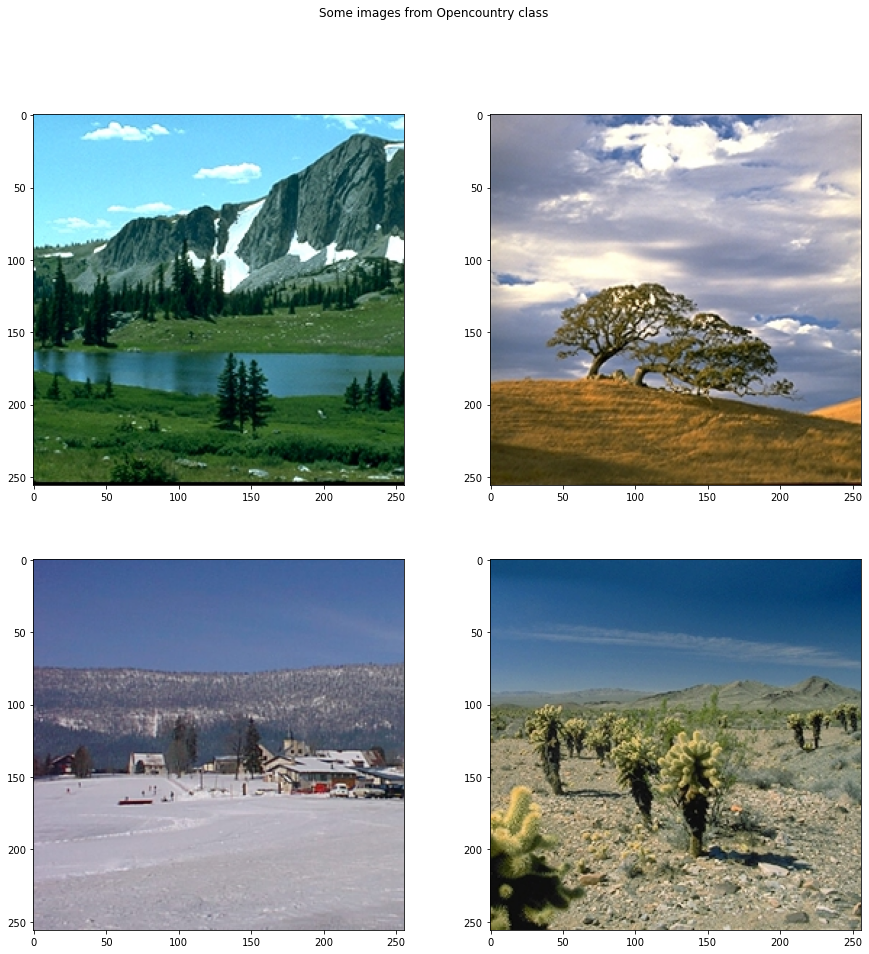

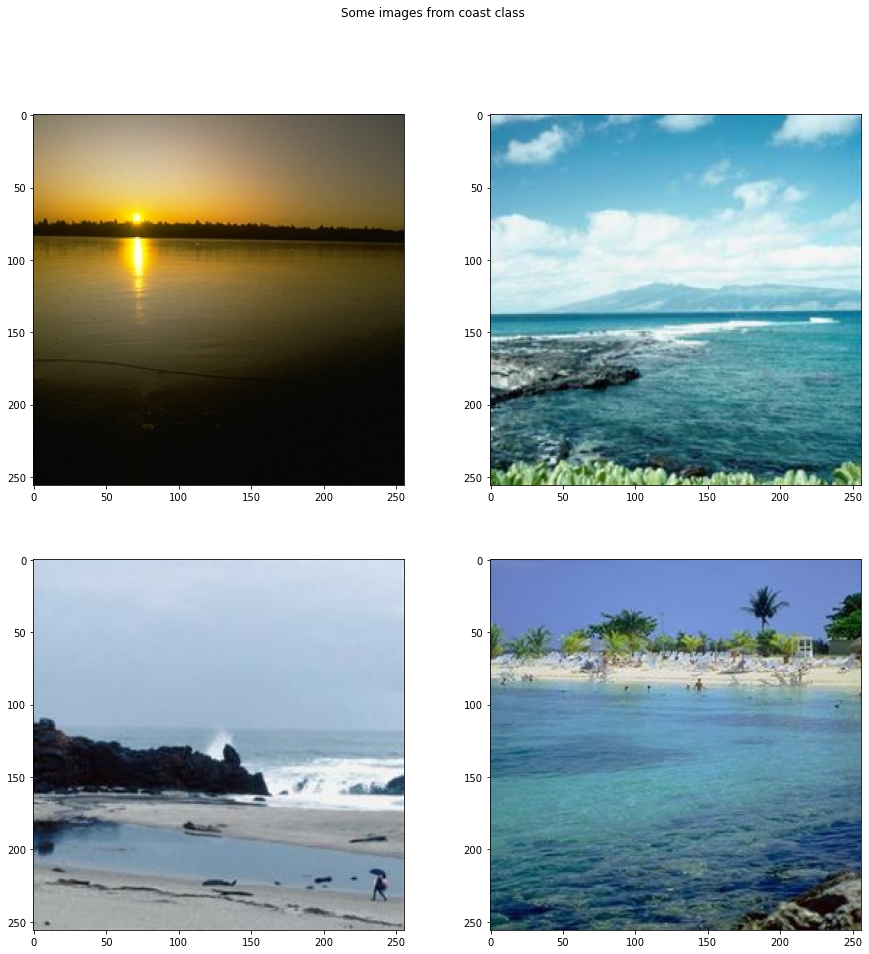

In [117]:
oc_imgs = [img for img in test_images_filenames if "Opencountry" in img]
random.shuffle(oc_imgs)

fig, axes = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle("Some images from Opencountry class")

for num, img in enumerate(oc_imgs[:4]):
    i = int(num/2)
    j = int(num%2)
    axes[i][j].imshow(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))

    
cst_imgs = [img for img in test_images_filenames if "coast" in img]
random.shuffle(cst_imgs)

fig, axes = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle("Some images from coast class")

for num, img in enumerate(cst_imgs[:4]):
    i = int(num/2)
    j = int(num%2)
    axes[i][j].imshow(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))